In [1]:
import os
import dmd
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv
from scipy.stats import linregress
from scipy.integrate import solve_ivp
from dask import array as da
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [2]:
filebase0='data/1ddmd/'
verbose=True

T=30
dt=0.002
def f(t,x):
    return -np.sin(x)**3
def f2(t,x):
    return -np.sin(x)

numtraj=5

evs=[]
ev2s=[]
bss=[]
bs2s=[]
dmin=500
dmax=2000
dd=500
ds=np.arange(dmin,dmax+1,dd)
ics=np.flip(np.pi/2*np.arange(1,numtraj+1)/(numtraj))

In [3]:
for num in ds:
    print(num)
    X=np.zeros((numtraj,int(T/dt),num+1))
    Xtraj=np.zeros((numtraj,int(T/dt)))
    X2=np.zeros((numtraj,int(T/dt),num+1))
    X2traj=np.zeros((numtraj,int(T/dt)))
    
    library_funcs=[lambda x: np.ones(x.shape)]+[lambda x, n=n: np.cos(n*x) for n in range(1,num//2+1)]+[lambda x, n=n: np.sin(n*x) for n in range(1,num//2+1)]
    lengths=[]
    for i in range(numtraj):
        sol=solve_ivp(f,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
        sol2=solve_ivp(f2,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
        t=sol.t
        y=sol.y
        y2=sol2.y
        X[i]=np.array([func(y[0]) for func in library_funcs]).T
        lengths=lengths+[y.shape[1]]
        Xtraj[i]=y[0]
        X2[i]=np.array([func(y2[0]) for func in library_funcs]).T
        X2traj[i]=y2[0]
    
    X=np.concatenate(X,axis=0)
    X2=np.concatenate(X2,axis=0)

    Xinds=np.setdiff1d(np.arange(np.sum(lengths)),np.cumsum(lengths)-1)
    Yinds=np.setdiff1d(np.arange(np.sum(lengths)),np.concatenate([[0],np.cumsum(lengths)[:-1]]))
    np.save(filebase0+'algebraic_Xtraj.npy',Xtraj)
    np.save(filebase0+'exponential_Xtraj.npy',X2traj)

    filebase=filebase0+'algebraic_%i'%(num)
    print(filebase)
    X=da.from_array(X)
    s,u,v=dmd.PCA(X[Xinds],filebase,verbose,save=False,load=False)
    evals,evecs,res,phis,bs,A=dmd.resDMD(u,v,s,X,Yinds,Xinds,filebase,verbose,save=True)
    
    filebase=filebase0+'exponential_%i'%(num)
    print(filebase)
    X2=da.from_array(X2)
    s2,u2,v2=dmd.PCA(X2[Xinds],filebase,verbose,save=False,load=False)
    evals2,evecs2,res2,phis2,bs2,A2=dmd.resDMD(u2,v2,s2,X2,Yinds,Xinds,filebase,verbose,save=True)

    
    ev2s=ev2s+[evals2[np.where(res2<1E-6)[0]]]
    bs2s=bs2s+[bs2[:,np.where(res2<1E-6)[0]]]
    evs=evs+[evals[np.where(res<1E-6)[0]]]
    bss=bss+[bs[:,np.where(res<1E-6)[0]]]

500
data/1ddmd/algebraic_500
svd runtime: 0.7716374294832349
s runtime: 5.984532314352691
numerical rank: 141
u runtime: 3.7065639896318316
v runtime: 3.9024508092552423
A runtime: 0.27446119114756584
Ktilde runtime: 0.41950473934412
eig runtime: 0.3643974522128701
amplitude runtime: 0.9312936356291175
res runtime: 0.7046558493748307
phis runtime: 0.0050141578540205956
revecsinv runtime: 0.0010421043261885643
phitildes runtime: 0.007459376007318497
data/1ddmd/exponential_500
svd runtime: 0.004818340763449669
s runtime: 3.819374291226268
numerical rank: 150
u runtime: 4.687925269827247
v runtime: 3.156303013674915
A runtime: 0.3580095963552594
Ktilde runtime: 0.3138963906094432
eig runtime: 0.0581739516928792
amplitude runtime: 1.172416395507753
res runtime: 0.7889181189239025
phis runtime: 0.005199894309043884
revecsinv runtime: 0.000243334099650383
phitildes runtime: 0.007249854505062103
1000
data/1ddmd/algebraic_1000
svd runtime: 0.0047630127519369125
s runtime: 8.509867975488305
num

In [4]:
num=2000
nr=51
ni=51
murs=-5+6*np.arange(nr)/(nr-1)
muis=-5+2*5*np.arange(ni)/(ni-1)

filebase=filebase0+'algebraic_%i'%(num)
inds=np.intersect1d(np.where(np.abs(np.real(np.log(evals)/dt))<5)[0],np.where(np.abs(np.imag(np.log(evals)/dt))<5)[0])
zs=np.concatenate([np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt),evals[inds]])
zs,pseudo,xis,its=dmd.resDMDpseudo(u.compute(),A,zs,evals,evecs,filebase,verbose,save=True)

filebase=filebase0+'exponential_%i'%(num)
inds2=np.intersect1d(np.where(np.abs(np.real(np.log(evals2)/dt))<5)[0],np.where(np.abs(np.imag(np.log(evals2)/dt))<5)[0])
zs2=np.concatenate([np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt),evals2[inds2]])
zs2,pseudo2,xis2,its2=dmd.resDMDpseudo(u2.compute(),A2,zs2,evals2,evecs2,filebase,verbose,save=True)

0.999623	1.000025	-0.001188
pseudospectra runtime: 2184.770665258169
0.999618	0.998002	0.0000000
pseudospectra runtime: 2373.6626266296953


In [12]:
filebase0='data/1ddmd/'

evs=[]
bss=[]
for i in range(len(ds)):
    filebase=filebase0+'algebraic_%i'%ds[i]
    evals=np.load(filebase+'evals.npy')
    res=np.load(filebase+'res.npy')
    bs=np.load(filebase+'bs.npy')
    evs=evs+[evals[np.where(res<1E-6)[0]]]
    bss=bss+[bs[:,np.where(res<1E-6)[0]]]
zs=np.load(filebase+'zs.npy')
pseudo=np.load(filebase+'pseudo.npy')

ev2s=[]
bs2s=[]
for i in range(len(ds)):
    filebase=filebase0+'exponential_%i'%ds[i]
    evals2=np.load(filebase+'evals.npy')
    res2=np.load(filebase+'res.npy')
    bs2=np.load(filebase+'bs.npy')
    ev2s=ev2s+[evals2[np.where(res2<1E-6)[0]]]
    bs2s=bs2s+[bs2[:,np.where(res2<1E-6)[0]]]
zs2=np.load(filebase+'zs.npy')
pseudo2=np.load(filebase+'pseudo.npy')

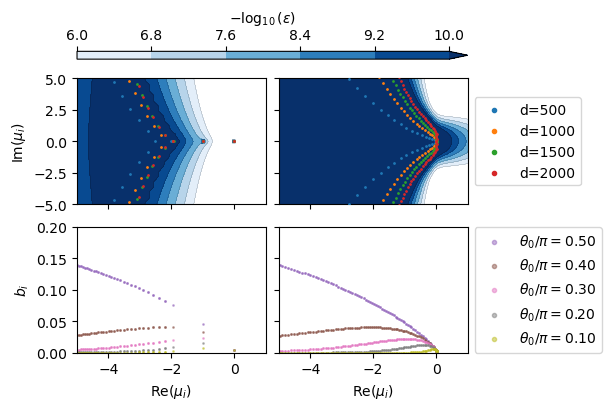

In [6]:
resmin=1E-6
resmax=1E-10
levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
markers=['>','v','^','<','o']
fig,axs=plt.subplots(2,2,figsize=(6,4),layout='constrained')

plt.subplot(2,2,1)
for i in range(len(ev2s)):
    plt.scatter(np.real(np.log(ev2s[i])/dt),np.imag(np.log(ev2s[i])/dt),s=1,label='d=%i'%ds[i],zorder=4)
plt.xlim(-5,1)
plt.ylim(-5,5)
# plt.title('$\dot{\phi}=-\sin(\theta)$')
plt.gca().set_xticklabels('')
plt.ylabel(r'$\mathrm{Im}(\mu_i)$')

cs1 = plt.gca().tricontourf(np.real(np.log(zs2)/dt),np.imag(np.log(zs2)/dt),np.log(1/np.array(pseudo2))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)


plt.subplot(2,2,2)
for i in range(len(evs)):
    plt.scatter(np.real(np.log(evs[i])/dt),np.imag(np.log(evs[i])/dt),s=1,label='d=%i'%ds[i],zorder=4)
# plt.title('$\dot{\phi}=-\sin(\theta)^3$')
plt.xlim(-5,1)
plt.ylim(-5,5)
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(pseudo))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)
fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))

plt.subplot(2,2,3)
# for i in range(len(ev2s)):
for i in [len(ev2s)-1]:
    # for j in range(numtraj//2):
    for j in range(numtraj):
        plt.scatter(np.real(np.log(ev2s[i])/dt),np.abs(bs2s[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4])
plt.xlim(-5,1)
plt.ylim(0,0.2)
plt.xlabel(r'$\mathrm{Re}(\mu_i)$')
plt.ylabel('$b_i$')

plt.subplot(2,2,4)
# for i in range(len(evs)):
for i in [len(evs)-1]:
    # for j in range(numtraj//2):
    for j in range(numtraj):
        if i==len(evs)-1:
            plt.scatter(np.real(np.log(evs[i])/dt),np.abs(bss[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4],label=r'$\theta_0/\pi=%.2f$'%(ics[j]/np.pi))
        else:
            plt.scatter(np.real(np.log(evs[i])/dt),np.abs(bss[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4])     
            
plt.xlim(-5,1)
plt.ylim(0,0.2)
plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\mathrm{Re}(\mu_i)$')
plt.gca().set_yticklabels('')


plt.savefig('1ddmd1.pdf')
plt.show()

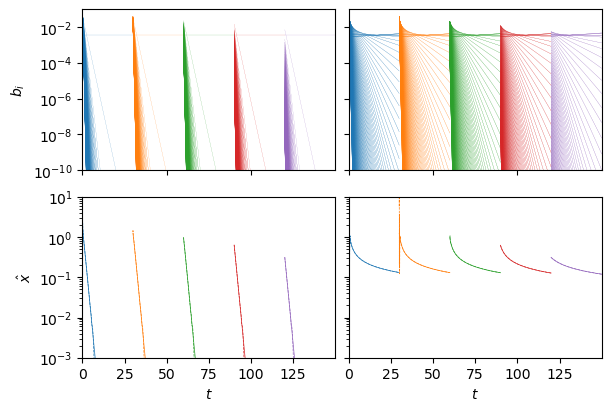

In [13]:
i=len(ds)-1
num=dmax
filebase=filebase0+'algebraic_%i'%ds[i]
evals=np.load(filebase+'evals.npy')
res=np.load(filebase+'res.npy')
bs=np.load(filebase+'bs.npy')
phis=np.load(filebase+'phis.npy')
phitildes=np.load(filebase+'phitildes.npy')
Xtraj=np.load('data/1ddmd/algebraic_Xtraj.npy')
filebase=filebase0+'exponential_%i'%ds[i]
evals2=np.load(filebase+'evals.npy')
res2=np.load(filebase+'res.npy')
bs2=np.load(filebase+'bs.npy')
phis2=np.load(filebase+'phis.npy')
phitildes2=np.load(filebase+'phitildes.npy')
X2traj=np.load('data/1ddmd/exponential_Xtraj.npy')


t=np.arange(len(bs))*dt
mus2=np.log(evals2)/dt
inds2=np.where(res2<1E-8)[0]
mus=np.log(evals)/dt
inds=np.where(res<1E-8)[0]
inds3=np.where(np.real(mus[inds])>-10)[0]
inds4=np.where(np.real(mus2[inds2])>-10)[0]

plt.subplots(2,2,figsize=(6,4),layout='constrained')

plt.subplot(2,2,1)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs2[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds2[inds4]]),c=colors[n],lw=0.1)

plt.yscale('log')
plt.ylim(1E-10,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])
plt.ylabel('$b_i$')

plt.subplot(2,2,2)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds[inds3]]),c=colors[n],lw=0.1)

plt.yscale('log')
plt.ylim(1E-10,1E-1)
plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
plt.ylim(1E-10,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])

nt=bs.shape[0]
nd=phis.shape[0]
X_reconstruct=np.zeros((nt,nd))
X_reconstruct2=np.zeros((nt,nd))
for n in range(numtraj):
    n0=nt//numtraj*n
    X_reconstruct[n0:n0+nt//numtraj]=np.real((bs[n0,inds]*phitildes[inds].T).dot(evals[inds,np.newaxis]**np.arange(nt//numtraj)[np.newaxis,:])).T
    X_reconstruct2[n0:n0+nt//numtraj]=np.real((bs2[n0,inds2]*phitildes2[inds2].T).dot(evals2[inds2,np.newaxis]**np.arange(nt//numtraj)[np.newaxis,:])).T

plt.subplot(2,2,3)
v=np.concatenate([np.zeros(num//2+1),-2/np.arange(1,num//2+1)*(-1)**np.arange(1,num//2+1)])
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X2traj[n])[:-1], c=colors[n],lw=0.5)    
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X_reconstruct2[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v)),c=colors[n],ls='--',lw=0.5)
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-3,1E1)
# plt.ylim(1E-6,1E1)
plt.ylabel(r'$\hat{x}$')
plt.xlabel('$t$')
# plt.xticks(t[::len(t)//numtraj],['']*numtraj)
# ytics=plt.gca().get_yticks()
# plt.gca().set_yticks(ytics)

plt.subplot(2,2,4)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(Xtraj[n])[:-1], c=colors[n],lw=0.5)
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X_reconstruct[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v)),c=colors[n],ls='--',lw=0.5)
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-3,1E1)

# plt.xticks(t[::len(t)//numtraj],['']*numtraj)
# plt.gca().set_yticks(ytics,['']*len(ytics))
# plt.ylim(1E-6,1E1)
# print(plt.gca().get_yticks())
plt.gca().set_yticklabels('')
plt.xlabel('$t$')

plt.savefig('1ddmd2.pdf')
plt.show()

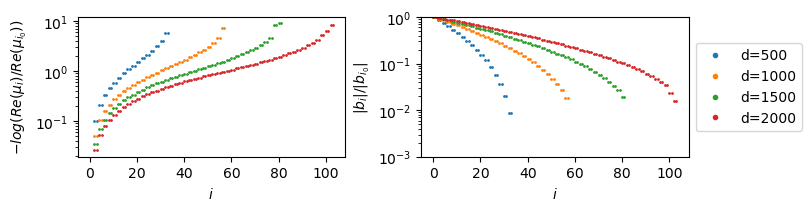

In [8]:
data=[np.concatenate([np.log(evs[i][:,np.newaxis])/dt,bss[i][::int(T/dt-1)].T],axis=1) for i in range(len(evs))]

plt.subplots(1,2,figsize=(8,2),layout='constrained')
plt.subplot(1,2,1)
for i in range(len(data)):
    xs=np.real(data[i][:,0])
    inds=np.where(-np.sort(xs)<5)[0]

    plt.subplot(1,2,1)
    sinds=np.intersect1d(np.where(-np.sort(xs)<3)[0],np.where(np.sort(xs)<0)[0])
    vals=xs[np.argsort(xs)][sinds]
    plt.plot(-np.log(vals/vals[0]),marker='o',lw=0,ms=1)
    plt.yscale('log')
    plt.ylabel(r'$-log(Re(\mu_i)/Re(\mu_{i_0}))$')
    plt.xlabel('$i$')

    plt.subplot(1,2,2)
    for m in range(1):
        bs0=data[i][:,m]
        vals=np.abs(bs0)[np.argsort(xs)][sinds]
        if m==0:
            plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='d=%i'%ds[i],c=colors[i])
        else:
            plt.plot(vals/vals[0],marker='o',lw=0,ms=1,c=colors[i])
        plt.yscale('log')
        plt.ylabel('$|b_i|/|b_{i_0}|$')
        plt.xlabel('$i$')
        plt.ylim(1E-3,1E0)

plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
plt.savefig('1ddmd3.pdf')


504 (4.551914400963121e-12+0j)


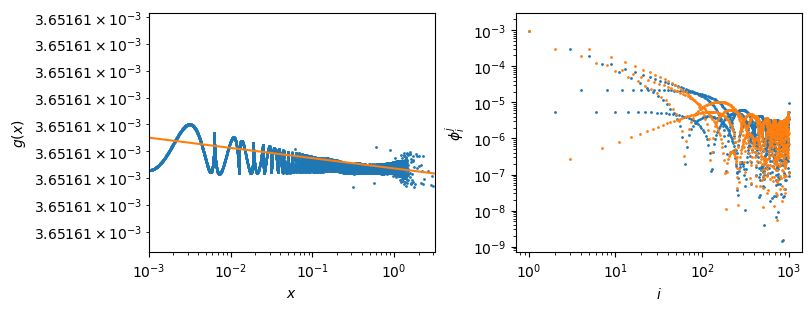

528 (-1.0000089687738096+0j)


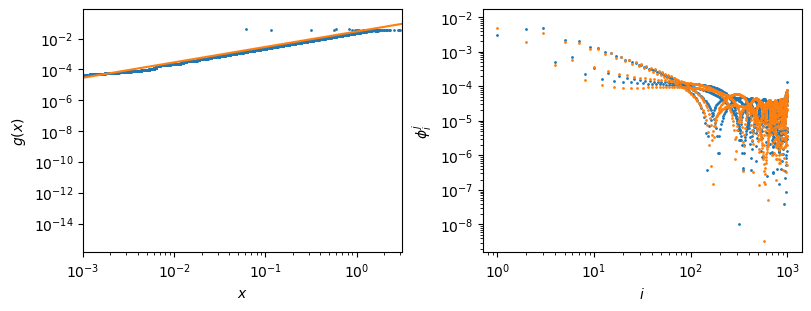

527 (-1.9344471066558873+0j)


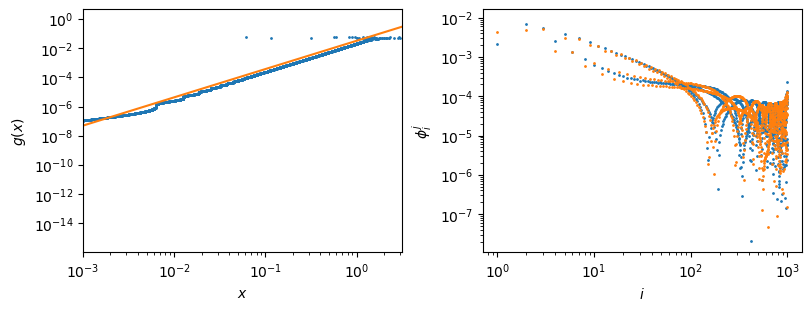

526 (-2.1916727519060486-0.47185724059129225j)


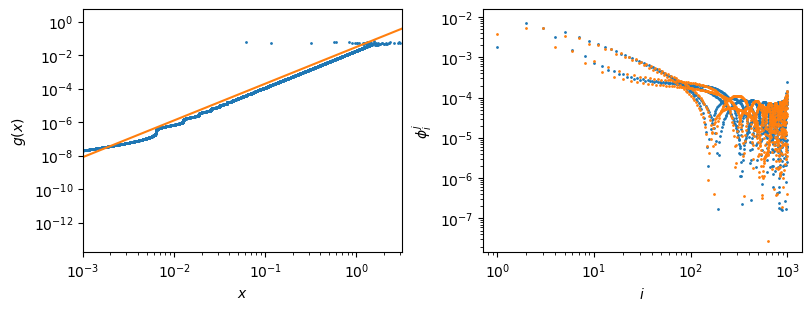

525 (-2.1916727519060486+0.47185724059129225j)


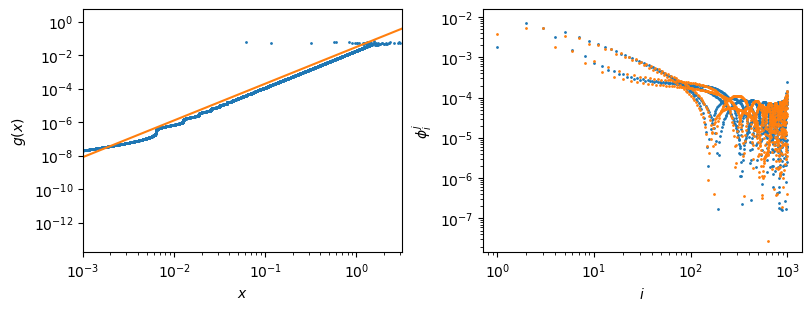

In [9]:
# The five leading Koopman mode in the exponential case; they approximate powers of x, as expected
num=ds[-1]
n=0
n0=0
for m in range(5):
    i=np.argsort(-np.real(mus2))[m]
    print(i,mus2[i])
    v=np.concatenate([np.zeros(num//2+1),-2/np.arange(1,num//2+1)*(-1)**np.arange(1,num//2+1)])
    XX2=X_reconstruct2[n*len(t)//numtraj+n0:(n+1)*len(t)//numtraj].dot(v)
    tinds=np.intersect1d(np.where(np.abs(bs2[:,i])>1E-8)[0],np.where(XX2>1E-3)[0])
    tinds=np.intersect1d(tinds,np.where(XX2<2*np.pi)[0])
    xs=np.min(XX2[tinds])+(np.max(XX2[tinds])-np.min(XX2[tinds]))*np.arange(10000)/10000

    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
#     plt.plot(xs,np.exp(reg.intercept)*xs**reg.slope,c=colors[1])
    scale=np.abs(bs2[n*len(t)//numtraj+n0,i])/np.abs(ics[n]**(-mus2[i]))
    
    plt.plot(xs,np.abs(scale*xs**(-mus2[i])),c=colors[1])
    plt.scatter(XX2[:],np.abs(bs2[n*len(t)//numtraj+n0:(n+1)*len(t)//numtraj,i]),s=1)
    # plt.scatter(X2[:,0],np.imag(bs2[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1E-3,np.pi)
    plt.xlabel('$x$')
    plt.ylabel('$g(x)$')
    

    plt.subplot(1,2,2)
    # plt.plot(np.real(phis2[:1,i]),marker='o',lw=0)
    plt.plot(np.abs(np.real(phis2[:num//2+1,i])),marker='o',lw=0,ms=1)
    plt.plot(np.abs(np.real(phis2[num//2+1:,i])),marker='o',lw=0,ms=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$i$')
    plt.ylabel(r'$\phi_i^j$')
    plt.show()

485 (0.015057782160291537-0.1911856968847872j)
0 (0.015057782160291537-0.1911856968847872j)


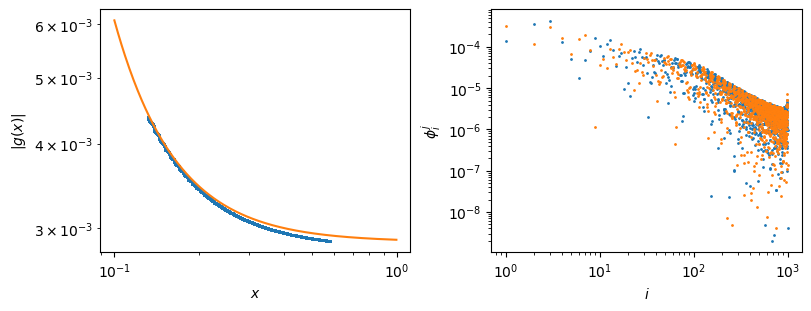

484 (0.015057782160291537+0.1911856968847872j)
0 (0.015057782160291537+0.1911856968847872j)


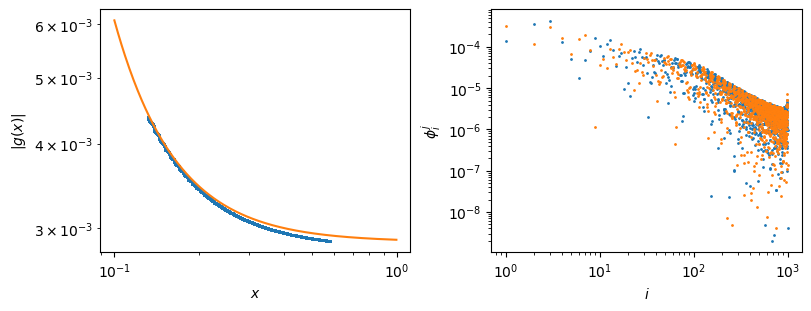

491 (0.01304507022231319-0.5941620630809451j)
0 (0.01304507022231319-0.5941620630809451j)


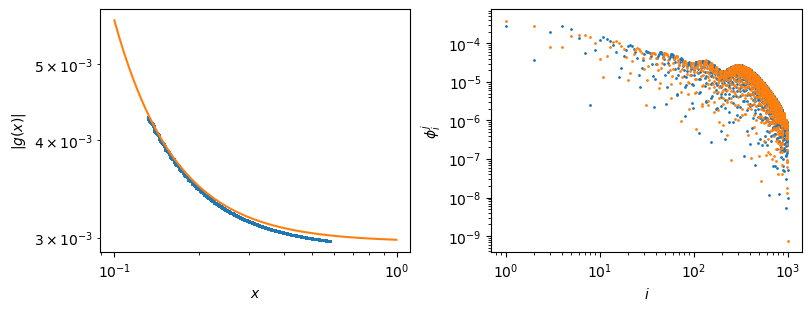

490 (0.01304507022231319+0.5941620630809451j)
0 (0.01304507022231319+0.5941620630809451j)


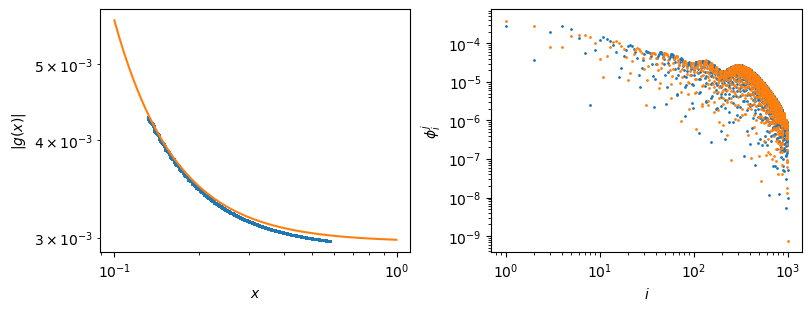

483 (0.010880788857255921-0.06762227231968639j)
0 (0.010880788857255921-0.06762227231968639j)


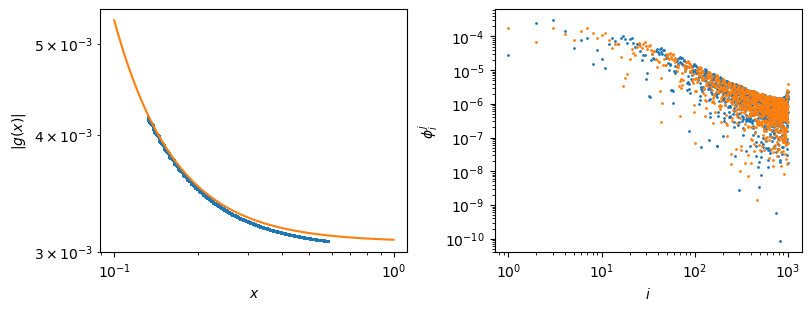

482 (0.010880788857255921+0.06762227231968639j)
0 (0.010880788857255921+0.06762227231968639j)


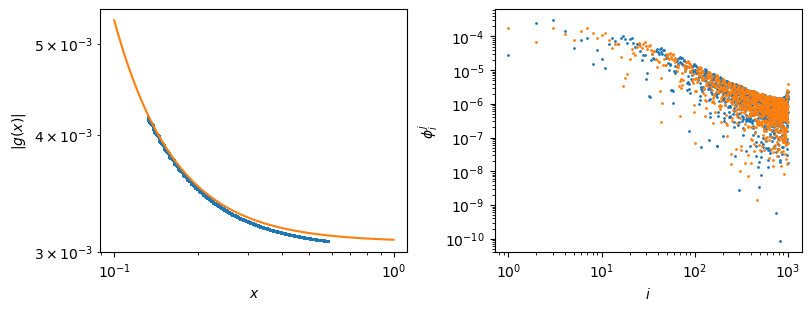

486 (-0.0006792737185539442+0.3217245748638836j)
0 (-0.0006792737185539442+0.3217245748638836j)


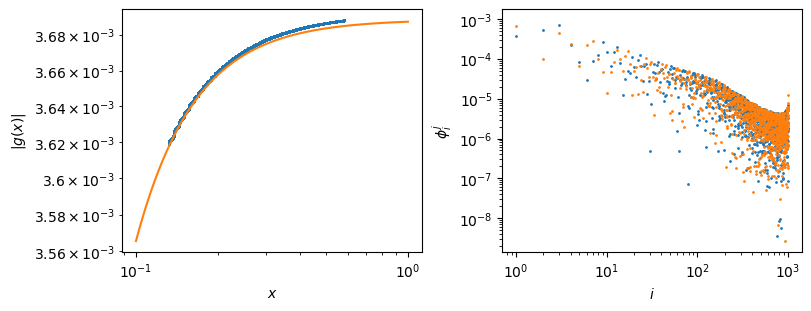

487 (-0.0006792737185539442-0.3217245748638836j)
0 (-0.0006792737185539442-0.3217245748638836j)


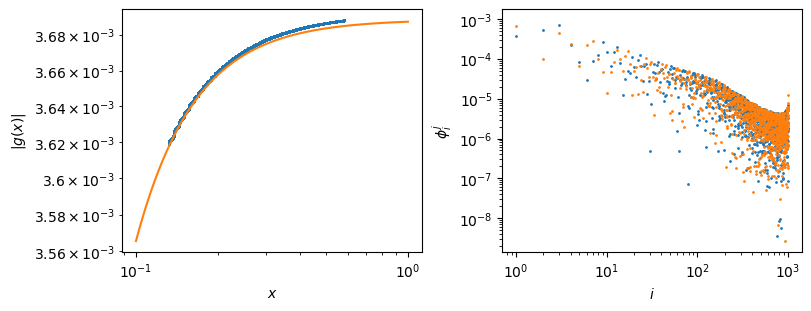

488 (-0.005689546741182743+0.4677964414803687j)
0 (-0.005689546741182743+0.4677964414803687j)


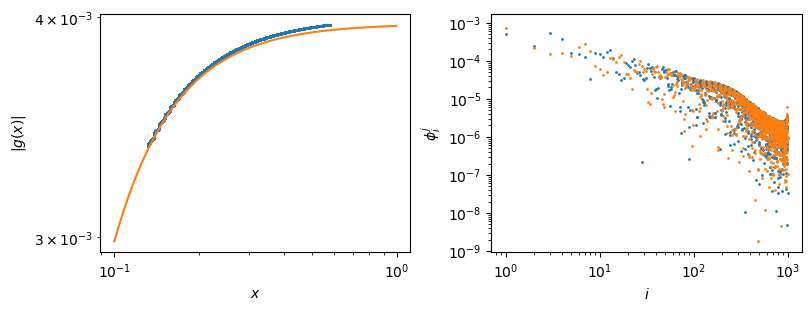

489 (-0.005689546741182743-0.4677964414803687j)
0 (-0.005689546741182743-0.4677964414803687j)


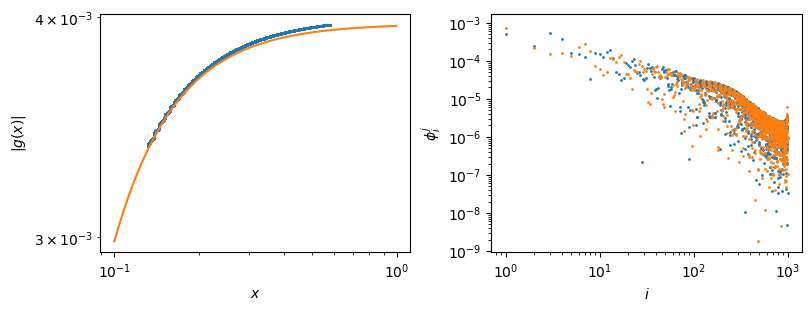

In [10]:
# The five leading Koopman mode in the algebraic case  
n=0
n0=1000
for m in range(10):
    i=np.argsort(-np.real(mus))[m]
    print(i,mus[i])
    v=np.concatenate([np.zeros(num//2+1),-2/np.arange(1,num//2+1)*(-1)**np.arange(1,num//2+1)])
    XX=X_reconstruct[n*len(t)//numtraj+n0:(n+1)*len(t)//numtraj].dot(v)
    
    print(n,mus[i])
    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
    plt.scatter(XX[:],np.abs(bs[n*len(t)//numtraj+n0:(n+1)*len(t)//numtraj,i]),s=1)
    xs=np.arange(100,1000)/1000
    scale=np.abs(bs[n*len(t)//numtraj+n0,i])/np.abs(np.exp(mus[i]/(2*ics[n]**2)))
    plt.plot(xs,scale*np.abs(np.exp(mus[i]/(2*xs**2))),c=colors[1])

    # plt.scatter(X[:,0],np.imag(bs[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$x$')
    plt.ylabel('$|g(x)|$')
    

    plt.subplot(1,2,2)
    # plt.plot(np.real(phis[:1,i]),marker='o',lw=0)
    plt.plot(np.abs(np.real(phis[:num//2+1,i])),marker='o',lw=0,ms=1)
    plt.plot(np.abs(np.real(phis[num//2+1:,i])),marker='o',lw=0,ms=1)
    plt.xlabel('$i$')
    plt.ylabel(r'$\phi_i^j$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

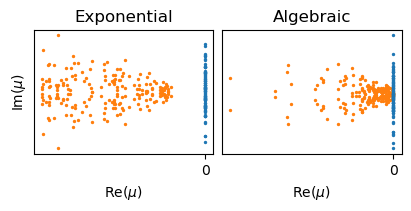

In [11]:
plt.subplots(1,2,figsize=(4,2),layout='constrained')

np.random.seed(1)
plt.subplot(1,2,1)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=np.random.uniform(-5,-1,size=numdecay)
ydecay=np.random.normal(0,5*(-1-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0])
plt.scatter(xdecay,ydecay,s=2,c=colors[1])
plt.scatter(xdecay,-ydecay,s=2,c=colors[1])
plt.xlabel(r'$\mathrm{Re}(\mu)$')
plt.ylabel(r'$\mathrm{Im}(\mu)$')
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Exponential')


plt.subplot(1,2,2)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=-np.random.exponential(1,size=numdecay)
ydecay=np.random.normal(0,5*(-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0],zorder=5)
plt.scatter(xdecay,ydecay,s=2,c=colors[1],zorder=4)
plt.scatter(xdecay,-ydecay,s=2,c=colors[1],zorder=4)
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Algebraic')
plt.xlabel(r'$\mathrm{Re}(\mu)$')
plt.savefig('schematic.pdf')
plt.show()